In [1561]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [1612]:
targets_df= pd.read_csv('../0_data/subset_targets.csv')
targets_df=targets_df.merge(uniprots, on=['chembl_id', 'pref_name']).drop(['year', 
                                                                           'canonical_smiles', 
                                                                           'lig_chemblid',
                                                                          'pchembl_value'],axis=1)


In [1663]:
from pubval import PubChemValidator
pcv = PubChemValidator(None, None, None)

In [1747]:
pcv.load_checkpoint()
print(len(pcv.predictions))

2232


In [1748]:
import tqdm
import pandas as pd

df = pd.DataFrame(columns=['tid', 'pref_name', 'lig_chemblid', 'active', 'inactive', 'nnrank', 'prob'])
count = 0 



for pred in tqdm.tqdm_notebook(pcv.predictions.keys()):
    lig, targ = pred.split(':')

    #target_synonyms = pcv.targets[targ]['synonyms']
    tid = pcv.targets[targ]['tid']
    pref_name = pcv.targets[targ]['pref_name']
    accession = pcv.targets[targ]['accession']
        
    ligand_chemblid = pcv.ligands[lig]['chemblid']
    
    
    #check if there are any active or inactive assays at all:
    actives = pcv.ligands[lig]['actives']
    inactives = pcv.ligands[lig]['inactives']
    
    num_actives = sum([1 if _==accession else 0 for _ in actives.values()])
    num_inactives = sum([1 if _==accession else 0 for _ in inactives.values()])
    
    if (num_actives+num_inactives) > 0:

        
        print( 'Actives:', num_actives, 'Inactives:', num_inactives )

        nn = pcv.predictions[pred]['nn']
        prob = float(pcv.predictions[pred]['prob'])

        df.loc[count] = [tid, pref_name, ligand_chemblid, num_actives, num_inactives, nn, prob]
        count+=1



/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Actives: 1 Inactives: 0
Actives: 0 Inactives: 1
Actives: 1 Inactives: 0
Actives: 0 Inactives: 1
Actives: 0 Inactives: 1
Actives: 0 Inactives: 1
Actives: 0 Inactives: 1
Actives: 1 Inactives: 0
Actives: 0 Inactives: 1
Actives: 0 Inactives: 1
Actives: 0 Inactives: 1
Actives: 0 Inactives: 1
Actives: 0 Inactives: 1
Actives: 1 Inactives: 0
Actives: 0 Inactives: 2
Actives: 3 Inactives: 0
Actives: 0 Inactives: 1
Actives: 1 Inactives: 0
Actives: 0 Inactives: 1
Actives: 0 Inactives: 1
Actives: 0 Inactives: 1
Actives: 3 Inactives: 0
Actives: 1 Inactives: 0
Actives: 0 Inactives: 1
Actives: 0 Inactives: 1
Actives: 1 Inactives: 0
Actives: 1 Inactives: 0
Actives: 1 Inactives: 0
Actives: 1 Inactives: 0
Actives: 27 Inactives: 0
Actives: 4 Inactives: 0
Actives: 46 Inactives: 0
Actives: 1 Inactives: 0
Actives: 2 Inactives: 0
Actives: 1 Inactives: 0
Actives: 28 Inactives: 0
Actives: 1 Inactives: 0
Actives: 0 Inactives: 1
Actives: 0 Inactives: 1
Actives: 2 Inactives: 1
Actives: 0 Inactives: 1
Actives: 0 In

In [1749]:
df = pd.DataFrame(columns=['tid', 'pref_name', 'lig_chemblid', 'outcome', 'nnrank', 'prob'])
count = 0 



for pred in tqdm.tqdm_notebook(pcv.predictions.keys()):
    lig, targ = pred.split(':')

    #target_synonyms = pcv.targets[targ]['synonyms']
    tid = pcv.targets[targ]['tid']
    pref_name = pcv.targets[targ]['pref_name']
    accession = pcv.targets[targ]['accession']
        
    ligand_chemblid = pcv.ligands[lig]['chemblid']
    
    
    #check if there are any active or inactive assays at all:
    actives = pcv.ligands[lig]['actives']
    inactives = pcv.ligands[lig]['inactives']
    
    num_actives = sum([1 if _==accession else 0 for _ in actives.values()])
    num_inactives = sum([1 if _==accession else 0 for _ in inactives.values()])
    
    nn = pcv.predictions[pred]['nn']
    prob = float(pcv.predictions[pred]['prob'])
    
    if (num_actives+num_inactives) > 0:
        for key, value in actives.items():
            if accession in value:
                df.loc[count] = [tid, pref_name, ligand_chemblid, 'Active', nn, prob]
                count+=1
        for key, value in inactives.items():
            if accession in value:
                df.loc[count] = [tid, pref_name, ligand_chemblid, 'Inactive', nn, prob]
                count+=1


/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [1750]:
df

,tid,pref_name,lig_chemblid,outcome,nnrank,prob
0,CHEMBL2185,Serine/threonine-protein kinase Aurora-B,CHEMBL1983111,Active,2.0,1.000000
1,CHEMBL2147,Serine/threonine-protein kinase PIM1,CHEMBL535,Inactive,9.0,1.000000
2,CHEMBL1974,Tyrosine-protein kinase receptor FLT3,CHEMBL1983111,Active,16.0,1.000000
3,CHEMBL262,Glycogen synthase kinase-3 beta,CHEMBL535,Inactive,6.0,0.999999
4,CHEMBL279,Vascular endothelial growth factor receptor 2,CHEMBL31965,Inactive,5.5,0.999999
...,...,...,...,...,...,...
307,CHEMBL205,Carbonic anhydrase II,CHEMBL571738,Active,3.0,0.994921
308,CHEMBL205,Carbonic anhydrase II,CHEMBL567544,Active,5.0,0.994921
309,CHEMBL1974,Tyrosine-protein kinase receptor FLT3,CHEMBL1996234,Active,5.5,0.994904
310,CHEMBL2815,Nerve growth factor receptor Trk-A,CHEMBL24828,Inactive,54.0,0.994892


# Do some pandas rearranging:

In [1751]:
#save all raw data:
df.sort_values(by='pref_name').to_csv('results.csv')

In [1752]:
#aggregate the multiple assays for each protein-ligand pair into an 'active', 'inactive', or 'equal' record. 

piv = df.pivot_table(index=['pref_name','lig_chemblid', 'prob', 'nnrank'], 
               columns='outcome', 
               aggfunc='size', 
               fill_value=0)
res = piv.reset_index()
res['result'] = np.sign(res['Active'] - res['Inactive'])
res['result'] = res['result'].apply(lambda x: {-1:'Inactive', 0:'Both', 1:'Active'}[x])
result = res.drop('Active', axis=1).drop('Inactive', axis=1)
result.reset_index(drop=True, inplace=True)#.head()
result

outcome,pref_name,lig_chemblid,prob,nnrank,result
0,Carbonic anhydrase I,CHEMBL1163382,0.998267,1.0,Active
1,Carbonic anhydrase I,CHEMBL1164420,0.998267,1.0,Active
2,Carbonic anhydrase I,CHEMBL1164504,0.998267,1.0,Active
3,Carbonic anhydrase I,CHEMBL1165071,0.998267,1.0,Active
4,Carbonic anhydrase I,CHEMBL1165726,0.998267,2.0,Active
...,...,...,...,...,...
152,Vascular endothelial growth factor receptor 3,CHEMBL31965,0.995940,5.5,Inactive
153,Vascular endothelial growth factor receptor 3,CHEMBL428690,0.999018,230.0,Inactive
154,Vascular endothelial growth factor receptor 3,CHEMBL91829,0.996968,13.0,Inactive
155,c-Jun N-terminal kinase 1,CHEMBL535,0.999791,67.0,Inactive


# Start plotting

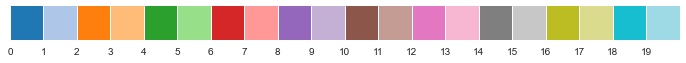

In [1753]:
from matplotlib import colors

def plot_fig_label(ax, lab):
    ax.text(0, 1.1, lab, transform=ax.transAxes,
        fontsize=24, va='top', ha='left')

def makeCmap(name, color_nums):
    cmap = plt.get_cmap(name)
    cmap2 = colors.ListedColormap([cmap.colors[i] for i in color_nums])
    #bounds=[i for i in range(len(color_nums))]
    #norm = colors.BoundaryNorm(bounds, cmap2.N)
    
    return cmap2#, norm
def view_colormap(cmap):
    """Plot a colormap"""
    if isinstance(cmap, str):
        cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    
    fig, ax = plt.subplots(1, figsize=(12, 3),
                           subplot_kw=dict(xticks=range(len(colors)), yticks=[]))
    ax.imshow([colors], extent=[0, len(colors), 0, 1])

    
view_colormap('tab20')

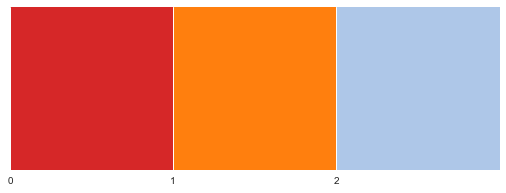

In [1754]:
cm = makeCmap('tab20', [6, 2, 1])
view_colormap(cm)

In [1755]:
def count_posi(df, rank):
    df_ = df[df['nnrank']>rank]
    pos = (df_['result']=='Active').sum()
    neg = (df_['result']=='Inactive').sum()
    return pos, neg

posi = np.zeros(150)
nega = np.zeros(150)
for i in range(1,151):
    pos, neg = count_posi(result, i)
    posi[i-1]=pos
    nega[i-1]=neg

tots = nega + posi


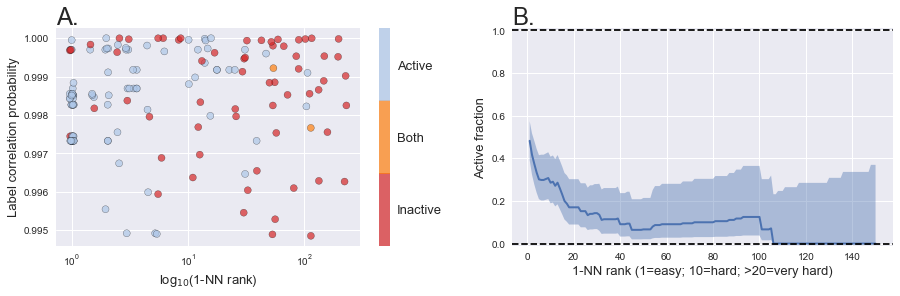

In [1756]:
fig, ax = plt.subplots(1,2)
#fig.set_figheight(15)
fig.set_figwidth(15)


jit = np.random.random(len(result))-0.5
jit /= 12
jit += 1

fsize=13

cax = ax[0].scatter(result['nnrank'].values*jit, 
            result['prob'].values.astype(float),
           c=result['result'].apply(lambda x: {'Active':1, 'Inactive':-1, 'Both':0}[x]),
           cmap = cm,
           alpha=0.7,
           edgecolor='k')
ax[0].set_xscale('log')

cbar = fig.colorbar(cax, ticks=[-0.66, 0, 0.66], ax=ax[0])
cbar.ax.set_yticklabels(['Inactive', 'Both', 'Active'], fontsize=fsize) 

ax[0].set_xlabel('log$_{10}}$(1-NN rank)', fontsize=fsize)
ax[0].set_ylabel('Label correlation probability', fontsize=fsize)


rate = posi/ tots

low = beta.ppf(0.025, posi+1, tots-posi+1)
high =beta.ppf(0.975, posi+1, tots-posi+1)

ax[1].fill_between(x=range(1,151),y1=low, y2=high,alpha=0.4)
ax[1].plot(range(1,151), rate, linewidth=2,)

ax[1].set_ylabel('Active fraction',fontsize=fsize)
ax[1].set_xlabel('1-NN rank (1=easy; 10=hard; >20=very hard)',fontsize=fsize)
ax[1].set_ylim(bottom=-0.01,top=1.01)
ax[1].axhline(0, linestyle='--', c='k')
ax[1].axhline(1, linestyle='--', c='k')

plot_fig_label(ax[0] ,'A.')
plot_fig_label(ax[1], 'B.')


fig.savefig('./figures/pubchem_validation.png')
fig.savefig('./figures/pubchem_validation.svg')
fig.savefig('./figures/pubchem_validation.tif')

In [1729]:
# stride = 12
# x = probs[probs.argsort()][::len(probs)//stride]
# digits = np.digitize(probs,x)
# nbin=len(x)
# for b in range(1,nbin):
# #for b in range(1,len(x[:-1])):
#     mask = digits==b
    
#     pos = ((d[0] - d[1])>0)[mask].sum()
#     neg = ((d[0] - d[1])<0)[mask].sum()
    
#     low = beta.ppf(0.025, pos+1, neg+1)
#     high = beta.ppf(0.975, pos+1, neg+1)
#     #print(pos/(pos+neg), low, high)
    
#     plt.plot([ x[b], x[b]], [low, high], c='k')
    
#     plt.scatter([x[b]], [pos/(pos+neg)],edgecolor = 'k', facecolor='white', linewidth=2)
    
# plt.ylim(0,1)
# plt.xlabel('Predicted probability')
# plt.ylabel('Hit rate')

### 

# Plotting target types:

In [1757]:
import altair as alt

def parse_groups(group):
    inactive = group['outcome'].str.contains('Inactive').sum()
    active = group['outcome'].str.contains('Active').sum()
    if (active - inactive) > 0:
        return 'Active'
    if (active - inactive) < 0:
        return 'Inactive'
    else:
        return 'Both'

collapse the assay data into per-ligand-target-pair results (i.e. `active`, `inactive`, `equal`).

Here also have the opportunity to select a protein family classification. 


In [1758]:
def parse_data(df, classification, lim=None):
    if lim is not None:
        df = df.groupby('pref_name').filter(lambda x : len(x)>lim)

    filtered_df = df.merge(target_types, on='pref_name')
    out = filtered_df[filtered_df['l1'].isin(classification)].groupby(['lig_chemblid', 'pref_name']).apply(parse_group2)

    out_df= pd.DataFrame(out).reset_index().drop('lig_chemblid',axis=1)

    out_df.columns=['pref_name', 'activity']
    return out_df
 
    

#Mask 1-NN solutions:
#out = df[df['nnrank']>0].groupby(['lig_chemblid', 'pref_name']).apply(parse_group2)

types = filtered_df.l1.unique()
t = types[4]
print(t)

parse_data(df, [types[0]])


Membrane receptor


,pref_name,activity
0,Dual specificity protein kinase CLK4,Inactive
1,Ribosomal protein S6 kinase 1,Active
2,Carbonic anhydrase I,Active
3,Carbonic anhydrase I,Active
4,Carbonic anhydrase I,Active
...,...,...
152,Fibroblast growth factor receptor 1,Inactive
153,Ribosomal protein S6 kinase alpha 3,Inactive
154,Serine/threonine-protein kinase PLK4,Inactive
155,Vascular endothelial growth factor receptor 2,Active


In [1759]:



def make_altair_long(df):
    ch = alt.Chart(df).mark_bar()

    ch = ch.encode(
        y = alt.Y('pref_name', sort='-x', title='Count'),
        x = alt.X('count()', title='Count'),
        color=alt.Color('activity'),
        order=alt.Order('activity', sort='ascending'),
        tooltip=['count()',]).properties(height=550,width=350).configure_axisY(
        titleFontSize=13,
            ).configure_axisX(
            titleFontSize=13
            ).configure_axisBottom(labelAngle=-35).configure_header(
                titleFontSize=40, 
                labelFontSize=40
            ).configure_axisY(
                titleAngle=0,
                titleAlign="left",
                titleY=-10,
                titleX=-20,
                titleFontSize=16,
            ).configure_legend(orient='bottom',labelFontSize=22)
    
    return ch



#make_altair_long(parse_data(df, [types[0]], 0))
make_altair_long(parse_data(df, types, 0))

alt.Chart(...)

In [1418]:
def make_altair_wide(df, h=200, w=650):
    ch = alt.Chart(df).mark_bar()

    ch = ch.encode(
        x = alt.X('pref_name', sort='-y', title='Target preferred name'),
        y = alt.Y('count()'),
        color=alt.Color('activity'),
        order=alt.Order('activity', sort='ascending'),
    ).properties(height=h,width=w).configure_axisX(labelAngle=40)
    return ch

ch1 = make_altair_wide(parse_data(df, [types[0]], 5))
ch2 = make_altair_wide(parse_data(df, [types[4]], 5), h=150, w=400)
ch3 = make_altair_wide(parse_data(df, types, 10), h=200, w=750)


In [1419]:
ch1

alt.Chart(...)

In [1420]:
ch2.save('./figures/receptors'

alt.Chart(...)

In [1423]:
ch3.save('./figures/all_target_classes.html')

In [991]:
temp = out_df.groupby('pref_name').filter(lambda x : len(x)>2)
ch = alt.Chart(temp).mark_bar()

# ch = ch.encode(
#     x = alt.X('pref_name', sort='-y', title='Target preferred name'),
#     y = alt.Y('count()'),
#     color=alt.Color('activity'),
#     order=alt.Order('activity', sort='ascending'),
# )

ch = ch.encode(
    y = alt.Y('pref_name', sort='-x', title='Target preferred name'),
    x = alt.X('count()', title='Count'),
    color=alt.Color('activity'),
    order=alt.Order('activity', sort='ascending'),
).properties(height=500,width=300)

# ch.configure_axisY(
# titleFontSize=13,
# ).configure_axisX(
# titleFontSize=13
# ).configure_axisBottom(labelAngle=-35).configure_header(
#     titleFontSize=40, 
#     labelFontSize=40
# ).configure_axisY(
#     titleAngle=0,
#     titleAlign="left",
#     titleY=-10,
#     titleX=-20,
#     titleFontSize=16,
# ).configure_legend(orient='bottom',labelFontSize=22)

ch

alt.Chart(...)

In [1350]:
ch = alt.Chart(out_df).mark_bar()

ch = ch.encode(
    x = alt.X('pref_name', sort='-y', title='Target preferred name'),
    y = alt.Y('count()'),
    color=alt.Color('activity'),
    order=alt.Order('activity', sort='ascending'),
).properties(height=200,width=750).configure_axisX(labelAngle=40)
ch



alt.Chart(...)

# Getting target classes:

In [894]:
target_types = pd.read_csv('target_classes.csv')

In [895]:
target_types

,chembl_id,l1,l2,l3,pref_name
0,CHEMBL3568,Enzyme,NaN,NaN,"Nitric-oxide synthase, brain"
1,CHEMBL2963,Enzyme,Protease,Metallo protease,Matrix metalloproteinase 15
2,CHEMBL2227,Ion channel,Other ion channel,Pore-forming toxins (proteins and peptides),Proenkephalin B
3,CHEMBL5208,Transporter,Electrochemical transporter,SLC superfamily of solute carriers,GABA transporter 3
4,CHEMBL3338,Enzyme,NaN,NaN,Squalene synthetase
...,...,...,...,...,...
3148,CHEMBL3989381,Unclassified protein,NaN,NaN,Hepcidin
3149,CHEMBL3989382,Unclassified protein,NaN,NaN,Macrophage colony-stimulating factor 1
3150,CHEMBL3989383,Unclassified protein,NaN,NaN,Tumor necrosis factor receptor superfamily mem...
3151,CHEMBL3989384,Unclassified protein,NaN,NaN,Cadherin-3


In [896]:
df.merge(target_types, on='pref_name')

,tid,pref_name,lig_chemblid,aid,outcome,title,nnrank,chembl_id,l1,l2,l3
0,CHEMBL261,Carbonic anhydrase I,CHEMBL2326507,727274,Inactive,inhibition of full length human recombinant fu...,1.5,CHEMBL261,Enzyme,Lyase,NaN
1,CHEMBL261,Carbonic anhydrase I,CHEMBL215355,271037,Active,inhibition of human cloned ca1 by co2 hydratio...,1.0,CHEMBL261,Enzyme,Lyase,NaN
2,CHEMBL261,Carbonic anhydrase I,CHEMBL215276,271037,Active,inhibition of human cloned ca1 by co2 hydratio...,1.0,CHEMBL261,Enzyme,Lyase,NaN
3,CHEMBL261,Carbonic anhydrase I,CHEMBL6852,47713,Active,inhibition of human carbonic anhydrase i cai,2.0,CHEMBL261,Enzyme,Lyase,NaN
4,CHEMBL261,Carbonic anhydrase I,CHEMBL6852,50367,Active,inhibitory activity against human carbonic anh...,2.0,CHEMBL261,Enzyme,Lyase,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2105,CHEMBL1914,Butyrylcholinesterase,CHEMBL3604192,1240923,Active,inhibition of equine serum bche using atc iodi...,1.0,CHEMBL1914,Enzyme,Hydrolase,NaN
2106,CHEMBL3973,Fibroblast growth factor receptor 4,CHEMBL3961994,1344879,Active,kinase hotspot xe2 xbf xa2 assay: compounds we...,1.5,CHEMBL3973,Enzyme,Kinase,Protein Kinase
2107,CHEMBL3973,Fibroblast growth factor receptor 4,CHEMBL3961994,1344879,Active,kinase hotspot xe2 xbf xa2 assay: compounds we...,1.5,CHEMBL3973,Enzyme,Kinase,Protein Kinase
2108,CHEMBL3973,Fibroblast growth factor receptor 4,CHEMBL3961994,1344881,Active,kinase hotspot xe2 xbf xa2 assay: compounds we...,1.5,CHEMBL3973,Enzyme,Kinase,Protein Kinase


In [1456]:
from chembl_webresource_client.new_client import new_client 
target = new_client.target
tid = 'CHEMBL204'
res = target.filter(target_chembl_id=tid)
res

[{'cross_references': [{'xref_id': 'P00734', 'xref_name': None, 'xref_src': 'canSAR-Target'}, {'xref_id': 'Thrombin', 'xref_name': None, 'xref_src': 'Wikipedia'}], 'organism': 'Homo sapiens', 'pref_name': 'Thrombin', 'species_group_flag': False, 'target_chembl_id': 'CHEMBL204', 'target_components': [{'accession': 'P00734', 'component_description': 'Prothrombin', 'component_id': 92, 'component_type': 'PROTEIN', 'relationship': 'SINGLE PROTEIN', 'target_component_synonyms': [{'component_synonym': '3.4.21.5', 'syn_type': 'EC_NUMBER'}, {'component_synonym': 'Activation peptide fragment 1', 'syn_type': 'UNIPROT'}, {'component_synonym': 'Activation peptide fragment 2', 'syn_type': 'UNIPROT'}, {'component_synonym': 'Coagulation factor II', 'syn_type': 'UNIPROT'}, {'component_synonym': 'F2', 'syn_type': 'GENE_SYMBOL'}, {'component_synonym': 'Prothrombin', 'syn_type': 'UNIPROT'}, {'component_synonym': 'Thrombin heavy chain', 'syn_type': 'UNIPROT'}, {'component_synonym': 'Thrombin light chain', 